In [1]:
from NinaPro_Utility import *

import tensorflow.compat.v1 as tf

tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from functools import reduce
from scipy import signal
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

# np_load_old = np.load

# # modify the default parameters of np.load
# np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# Data Gathering

Let's get the data from the directory '/scratch/pp1991/DB2/DB2_s1/' that has file 'S1_E1_A1.mat' using the `get_data()`

In [9]:
data = get_data('/scratch/pp1991/DB2/DB2_s1/','S1_E1_A1.mat')

In [10]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,stimulus,repetition
0,-0.000003,3.355261e-06,1.598866e-06,-0.000001,-0.000002,2.749975e-06,-2.347791e-06,1.537436e-07,-2.484787e-07,0.000001,-5.609089e-06,0.000040,0,0
1,-0.000005,3.355212e-06,1.430441e-06,-0.000003,-0.000003,2.246543e-06,-1.657156e-07,2.503453e-06,-3.561109e-07,0.000002,-3.259393e-06,0.000050,0,0
2,-0.000003,4.026560e-06,9.263165e-07,-0.000005,-0.000004,1.239568e-06,2.352061e-06,5.524560e-06,-2.445606e-07,0.000002,-7.045269e-08,0.000047,0,0
3,0.000002,2.851566e-06,7.578904e-07,-0.000007,-0.000004,1.575385e-06,2.016400e-06,5.188681e-06,1.094450e-06,0.000003,1.439995e-06,0.000032,0,0
4,0.000004,6.694763e-07,1.764409e-06,-0.000005,-0.000006,7.362596e-07,8.414949e-07,8.244234e-07,1.154750e-06,0.000003,9.700835e-08,0.000014,0,0


In [11]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,stimulus,repetition
count,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06
mean,4.808208e-09,-7.357209e-10,-4.197119e-07,2.112322e-09,-1.398447e-10,8.477198e-10,2.029853e-09,2.024880e-08,9.771656e-09,-4.893328e-07,2.336828e-09,7.045426e-09,3.386753e+00,2.180416e+00
std,4.115429e-05,2.760299e-05,4.324342e-05,4.576067e-05,1.159764e-05,1.033350e-05,4.762980e-05,7.486290e-05,4.731058e-05,5.242014e-05,7.782818e-06,3.717509e-05,5.210184e+00,2.165587e+00
min,-1.414742e-03,-1.417531e-03,-5.499916e-03,-1.693960e-03,-3.886087e-04,-2.764023e-04,-1.990281e-03,-1.453127e-03,-1.497044e-03,-1.662379e-03,-1.226652e-04,-4.916440e-04,0.000000e+00,0.000000e+00
25%,-4.978786e-06,-3.936091e-06,-3.251690e-06,-2.873654e-06,-2.693712e-06,-2.851705e-06,-5.523253e-06,-5.870371e-06,-3.371552e-06,-8.236710e-06,-2.273728e-06,-7.771074e-06,0.000000e+00,0.000000e+00
50%,1.466555e-07,3.258234e-07,6.282035e-09,8.234291e-08,7.752094e-08,1.029062e-07,1.287111e-06,8.321901e-07,-1.532981e-07,-9.468358e-07,-6.239010e-08,-7.593062e-07,0.000000e+00,2.000000e+00
75%,5.056879e-06,4.663832e-06,3.371931e-06,3.101591e-06,2.885123e-06,3.037450e-06,8.765568e-06,1.014123e-05,2.954850e-06,6.279086e-06,2.107727e-06,4.587339e-06,6.000000e+00,4.000000e+00
max,1.247256e-03,5.895796e-04,5.498070e-03,2.179232e-03,3.563007e-04,3.291671e-04,1.541105e-03,1.005659e-03,1.201373e-03,2.007309e-03,2.103748e-04,8.960569e-04,1.700000e+01,6.000000e+00


The retrieved data is in the form of a DataFrame. The first 12 columns correspond to the data from 12 channels sensor input. The `stimulus` correpond to the gesture label. The repetition is the repetition number of the trial. 

Let's now see how the data looks like. We only plot first 1000 rows from the data since the whole data is very large.

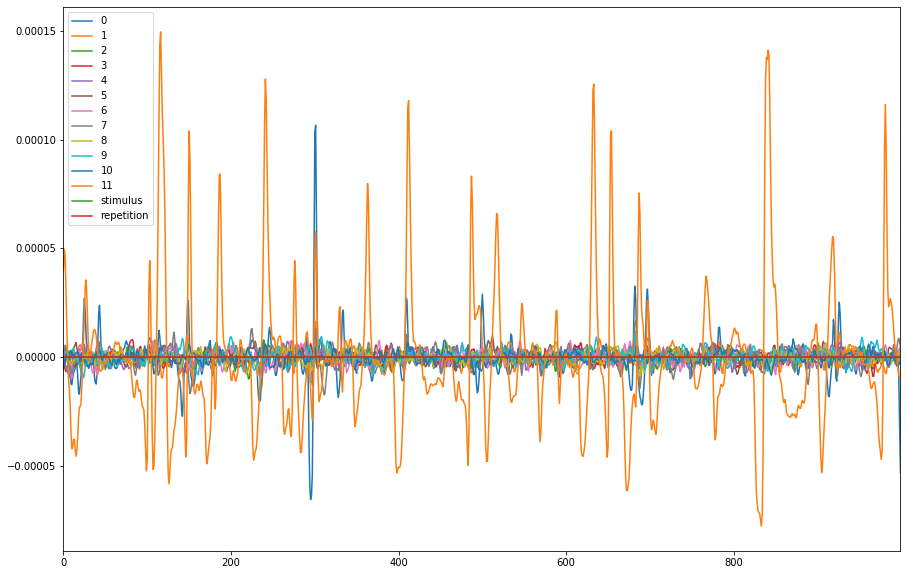

In [12]:
data[:1000].plot(figsize = (15,10))

According to the original research paper (http://www.nature.com/articles/sdata201453), it is recommended that we use reps 1,3,4 and 6 as training data and reps 2 and 5 as test data.

In [3]:
train_reps = [1,3,4,6]
test_reps = [2,5]

Since the data has a varying scale and the values are very small, we will do the scaling of data. We have already defined the train reps and test reps. `normalise()` needs the data and the train reps to scale the data with zero mean and unit standard deviation.

`normalise()` uses the `StandardScaler()` from scikit-learn to normalize the data. It fits on training reps only and then transforms the whole data (excluding `stimulus` and `repetition` ofcourse)

In [4]:
data = normalise(data, train_reps)

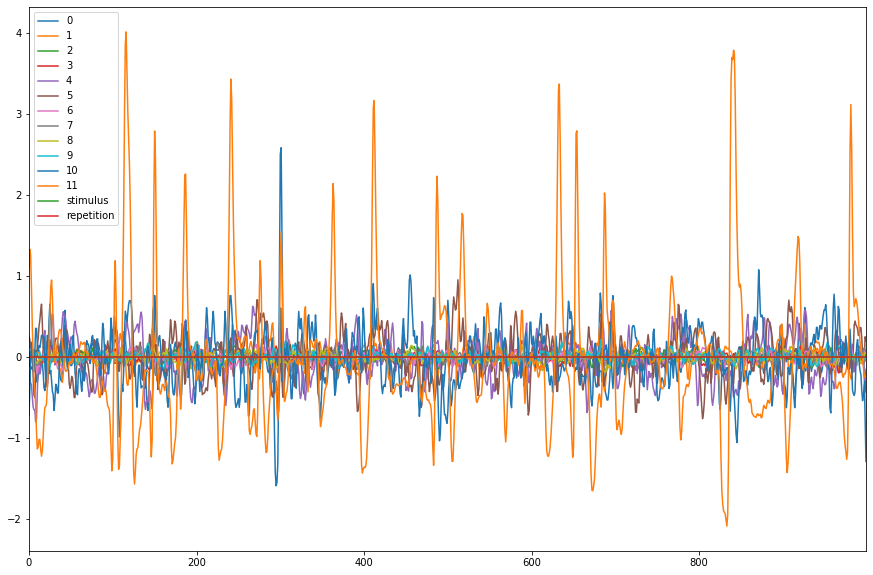

In [7]:
data[:1000].plot(figsize=(15,10))

## Filtering Signals

Sometimes, it is required that the signal is filtered with low noise or high noise frequencies. `filter_data` uses Butterworth filter to filter the data. It requires the cutoff frequency, the butterworth order, and the type of filter (btype is one of `lowpass`, `highpass`, `bandpass`). 

The `bandpass` filter requires the `f` value to be a tuple or a list containing lower cutoff frequency and higher cutoff frequency. 

In [8]:
emg_low = filter_data(data=data, f=20, butterworth_order=4, btype='lowpass') 
emg_band = filter_data(data=data, f=(20,40), butterworth_order=4, btype='bandpass') 
emg_high = filter_data(data=data, f=20, butterworth_order=4, btype='high') 

In [9]:
emg_low.head()

,0,1,2,3,4,5,6,7,8,9,10,11,stimulus,repetition
0,-6.235299e-08,1.092388e-07,4.194083e-08,-2.741651e-08,-1.612857e-07,2.390335e-07,-4.432692e-08,1.602173e-09,-4.904494e-09,3.358186e-08,-6.478103e-07,9.709659e-07,0,0
1,-5.912539e-07,9.652132e-07,3.670824e-07,-2.752030e-07,-1.501094e-06,2.068286e-06,-3.505023e-07,4.235716e-08,-4.537932e-08,3.140047e-07,-5.452678e-06,8.806458e-06,0,0
2,-2.767188e-06,4.322773e-06,1.609894e-06,-1.416766e-06,-7.070685e-06,8.936871e-06,-1.334033e-06,3.485151e-07,-2.090416e-07,1.474895e-06,-2.274054e-05,4.017514e-05,0,0
3,-8.623201e-06,1.334822e-05,4.831623e-06,-5.039514e-06,-2.292369e-05,2.640171e-05,-3.319660e-06,1.620160e-06,-6.286767e-07,4.742232e-06,-6.413275e-05,1.253068e-04,0,0
4,-2.037963e-05,3.238001e-05,1.141360e-05,-1.399095e-05,-5.854890e-05,6.131688e-05,-6.192746e-06,5.213826e-06,-1.371138e-06,1.195443e-05,-1.407028e-04,3.051472e-04,0,0


### Plotting the filtered data with 'lowpass' filter

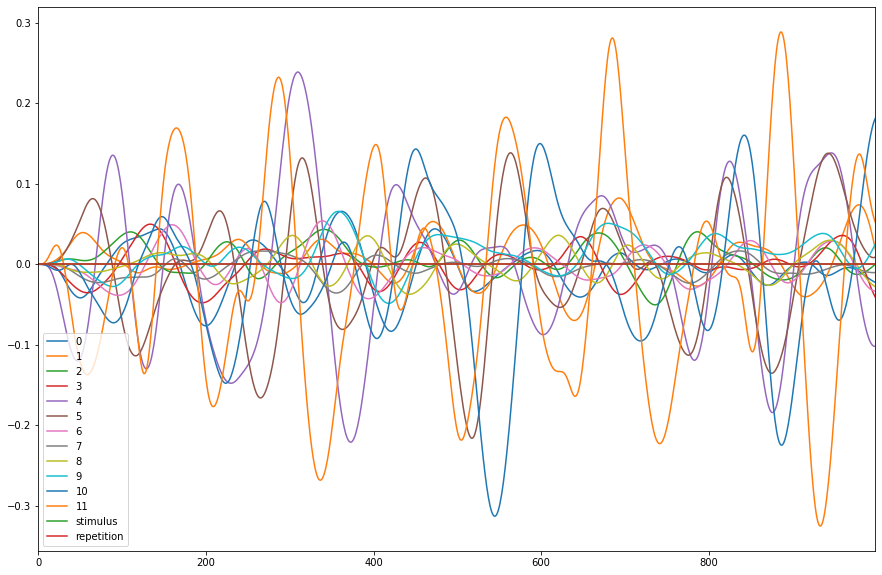

In [10]:
emg_low[:1000].plot(figsize = (15,10))

### Plotting the filtered data with 'bandpass' filter

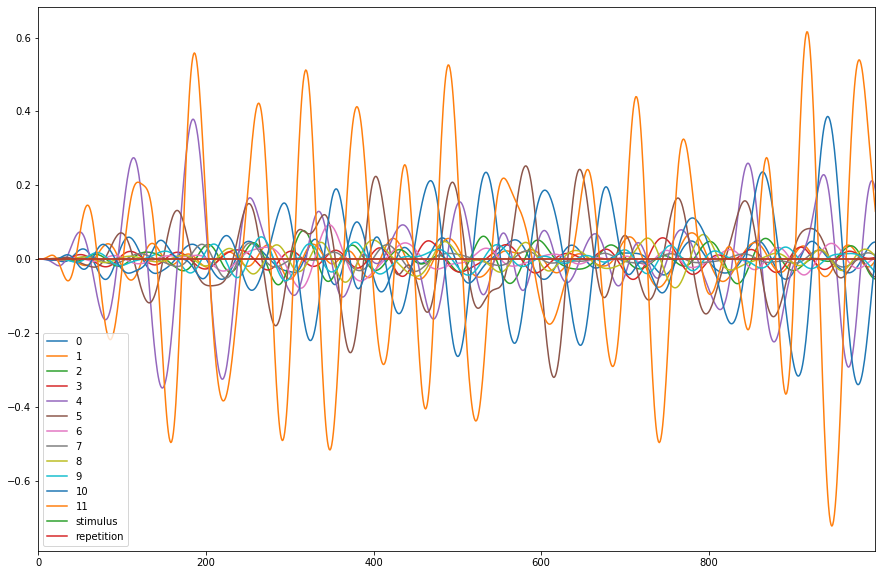

In [11]:
emg_band[:1000].plot(figsize = (15,10))

### Plotting the filtered data with 'highpass' filter

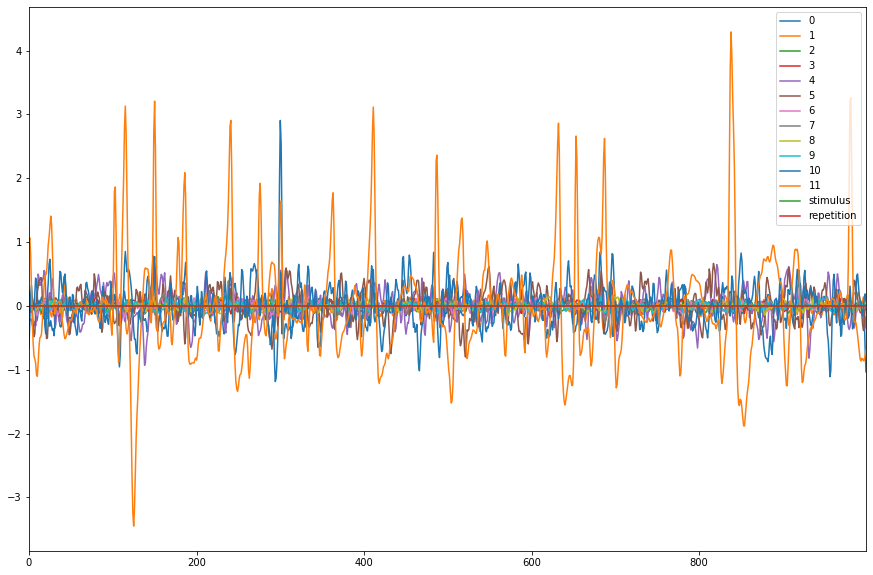

In [12]:
emg_high[:1000].plot(figsize = (15,10))

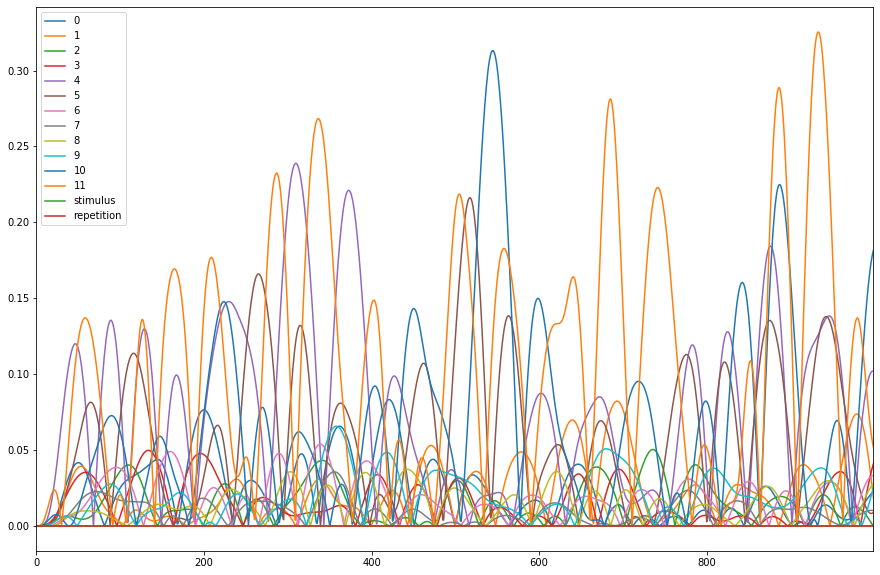

In [18]:
emg_rectified = rectify(emg_low)
emg_rectified[:1000].plot(figsize = (15,10))

Let's see number of gestures available in data.

In [20]:
np.unique(data.stimulus)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int8)

The `0` represent the rest state and does not signify a gesture (refer http://www.nature.com/articles/sdata201453), we only need gestures 1 to 17.

In [10]:
gestures = [i for i in range(1,18)]

The sampling frequency of the signal is 2kHz. So We want the data to be split in windows of 300ms with a stride of 10ms. 

300ms of data means 600 timestamps and similarly 10 ms of data means 20 timestamps.

In [11]:
win_len = 600
win_stride = 20

In [12]:
X_train, y_train, r_train = windowing(emg_filtered, train_reps, gestures, win_len, win_stride)

In [13]:
X_test, y_test, r_test = windowing(emg_filtered, test_reps, gestures, win_len, win_stride)

For multiclass classification, we need the labels to be represented in one-hot representation.

`get_categorical()` helps in converting the integer labels to one-hot representation. 

In [14]:
y_train = get_categorical(y_train)
y_test = get_categorical(y_test)

## Model
Let's define a model to classify the signals. The model defined here is very naive and may not generalize well. The whole purpose of the this is to demonstrate the functioning of various methods in NinaPro_Utility library.

In [23]:
def get_model(X_train):
    nodes = X_train.shape[1]
    
    inputs = Input(shape=(nodes,12))    
    LSTM_1 = LSTM(nodes, dropout=0.2, return_sequences=True)(inputs)
    LSTM_2 = LSTM(nodes, dropout=0.2, return_sequences=True)(LSTM_1)    
    LSTM_3 = LSTM(nodes, dropout=0.2, return_sequences=True)(LSTM_2)
    LSTM_4 = LSTM(nodes, dropout=0.2, return_sequences=True)(LSTM_3)
          
    x = Flatten()(LSTM_4)
    
    dense1 = Dense(128, activation = 'sigmoid')(x)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation = 'sigmoid')(dense1)
    dropout2 = Dropout(0.5)(dense2)
    predictions = Dense(17, activation = 'softmax')(dropout2)
    
    model = Model(inputs=inputs,outputs=predictions)
    
    return model

In [ ]:
model = get_model(X_train)

### Train Model

`train_model()` requires the model you have defined (remember the library does not give you any model. You need to define a model of your choice). 

The function also requires `X_train`, `y_train`, `X_test`, `y_test` for the training and validation.

The `save_to` arguement is required to save the model in h5 format. Last arguement is number of epochs that you want the training to continue for.

The `train_model()` uses two callbacks : EarlyStopping, ModelCheckpoint.

The it monitors `val_categorical_accuracy` and saves the model with `max` validation accuracy. 

In [95]:
histories, model = train_model(model, X_train, y_train, X_test, y_test, save_to= 'temp', epoch = 300)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Qr in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DiagPart in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sign in device /job:localhost/replica:0/task:0